# Kaggle - Titanic - Machine Learning from Disaster - Part 2

In this exercise you will update your submission to the titanic competition.

a) First let's add new numerical features / columns to the datasets that might be related to the survival of individuals.

- `has_cabin` should have a value of 0 if the `cabin` feature is `nan` and 1 otherwise
- `family_members` should have the total number of family members (by combining `SibSp` and `Parch`)
- `title_type`: from the title extracted from the name, we will categorize it into 2 types: `common` for titles that many passengers have, `rare` for titles that few passengers have. Map `common` to 1 and `rare` to 0. Describe what threshold you used to define `common` and `rare` titles and how you found it.
- `fare_type`: using Kmeans clustering on the fare column, find an appropriate number of clusters / groups of similar fares. Using the clusters you created, `fare_price` should be an ordinal variable that represents the expensiveness of the fare. For example if you split fare into 3 clusters ( 0 - 15, 15 - 40, and 40+ ) then the `fare_price` value should be `0` for `fare` values 0 - 15, `1` for 15 - 40, and `2` for 40+.
- Create an addition two numerical features of your invention that you think could be relevant to the survival of individuals.

Note: The features must be numerical because the sklearn `DecisionTreeClassifier` can only take on numerical features.

In [199]:
import pandas as pd
import numpy as np

train_Data_DF = pd.read_csv("./Data/train.csv")
test_Data_DF = pd.read_csv("./Data/test.csv")

- The has_cabin feature could tell us whether having a cabin or not influenced whether a person survived or not.

- Family_members is a combination of SibSp and Parch plus 1 (for the passenger themselves). This feature can be useful to understand if having family members on board affects a passenger's survival rate.

In [200]:
for df in [train_Data_DF, test_Data_DF]:
     # Set 'has_cabin' to 1 if 'Cabin' is not null, 0 otherwise
    df['has_cabin'] = np.where(df['Cabin'].notnull(), 1, 0)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

For title_type like last time we'll use regex first to extract them:

- train_Data_DF['Name'] accesses the Name column in the training DataFrame.

- .str.extract(' ([A-Za-z]+)\.', expand=False) applies the regular expression to each name, extracting the title.
    - (space): The search starts after a space, ensuring we don't start extracting from the beginning of the Lastname.

    - ([A-Za-z]+): This part captures one or more (+) alphabetical characters (A-Za-z). This is where the title will be matched, as titles are made up of letters only.
    
    - \.: This looks for a literal period (.). Titles in the dataset are followed by a period (e.g., "Mr."), making this a reliable way to end the capture.

- The extracted title is then assigned to a new column in the DataFrame called 'Title'.



In [201]:
# Extract titles from the Name column
train_Data_DF['Title'] = train_Data_DF['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_Data_DF['Title'] = test_Data_DF['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [202]:
for df in [train_Data_DF, test_Data_DF]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Master'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace(['Miss', 'Mrs', 'Mr'], 'Common')

The code provided does a few things (same as the first notebook):

- It first replaces rare titles (like 'Lady', 'Countess', 'Capt', 'Col', etc.) with 'Rare'. This groups various titles of nobility or uncommon professional titles into a single 'Rare' category, acknowledging their unique status without overcomplicating the model.

- It replaces titles with their common equivalents, such as converting 'Mlle' and 'Ms' to 'Miss', and 'Mme' (Madame) to 'Mrs', to ensure consistency in the dataset.

- The distinction is that we are combining the titles into either rare or common as per the requirements. However I do think slightly more variation would benefit the model.

### Kmeans Clustering on Fare

First the distinction on fare type and fare price:

- fare_type: This column represents the cluster labels assigned by the KMeans algorithm based on the Fare value for each passenger. These labels are integers (0, 1, 2, ..., N-1, where N is the number of clusters) that indicate the cluster each passenger's fare belongs to. However, these labels are assigned based on the clustering algorithm's internal logic and do not necessarily correspond to the ordinal ranking of the fare amounts. For example, cluster 0 could correspond to the highest fare values, cluster 1 to the lowest, and cluster 2 to the medium, depending on how the clustering algorithm groups the data.

- fare_price: This column is derived from the fare_type labels and represents an ordinal variable that ranks the expensiveness of the fare from least to most expensive. The transformation from fare_type to fare_price involves sorting the cluster centers (average fare values of each cluster) to understand which cluster corresponds to which level of fare expensiveness. Then, a mapping is applied to convert the cluster labels (fare_type) into a meaningful ordinal sequence (fare_price). This means if cluster 2 has the lowest average fare, it would be mapped to 0 in fare_price, indicating the least expensive tier of fares.

In essence, fare_type is an intermediate step that assigns each passenger to a cluster based on fare, but it doesn't inherently order these clusters by the average fare within them. fare_price takes the additional step of ordering these clusters to create a meaningful, ordinal categorization of fare expensiveness.



In [203]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Step 1: Determine the number of clusters using the elbow method
# Extract the Fare column values as a matrix
fare_values_train = train_Data_DF['Fare'].values.reshape(-1, 1)



### What is Inertia?
Inertia, in the context of KMeans, quantifies how far away the points within a cluster are from their centroid. A lower inertia value indicates that the points in each cluster are closer to each other and to their respective centroid, suggesting a better fit of the model to the data. However, as the number of clusters k increases, inertia naturally decreases because the clusters get smaller and their centers are closer to the points within them.

### Purpose of Calculating Inertia for Different k Values
The purpose of calculating and plotting the inertia for different k values is to apply the elbow method to determine the optimal number of clusters. When you plot the inertias (y-axis) against the number of clusters k (x-axis), you look for an "elbow" point where the rate of decrease of inertia sharply changes. Before this point, adding more clusters significantly reduces inertia, suggesting that the additional cluster provides a better fit to the data. After this point, the reduction in inertia slows down, indicating that additional clusters do not contribute as much to explaining the data variance and might lead to overfitting.

In [204]:
# Calculate the sum of squared distances for different numbers of clusters
ssd = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(fare_values_train)
    ssd.append(kmeans.inertia_)

/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

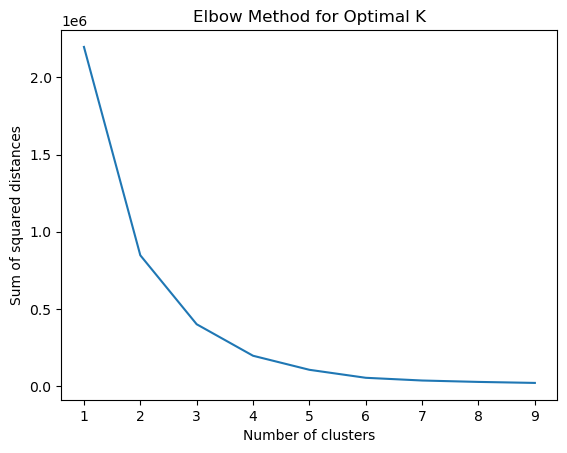

In [205]:
# Plot the elbow curve
plt.plot(range(1, 10), ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K')
plt.show()

At around 4 clusters the change of ssd starts to diminish and increasing clusters at that point may lead to overfitting.

In [206]:
# Step 2: Fit KMeans with the chosen number of clusters (e.g., 3 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(fare_values_train)

train_Data_DF['fare_type'] = kmeans.predict(fare_values_train)


/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [207]:
from sklearn.impute import SimpleImputer

# Apply the same transformation to the test data
# Test data has missing values so have to fill in those values
# using the median to try and avoid affecting the data too much

imputer = SimpleImputer(strategy="median")

# Fit the imputer on the training data
# on the training data to avoid data leakage
imputer.fit(train_Data_DF['Fare'].values.reshape(-1, 1))

fare_values_test = imputer.transform(test_Data_DF['Fare'].values.reshape(-1, 1))
test_Data_DF['fare_type'] = kmeans.predict(fare_values_test)

In [208]:
# Step 3: Sort the clusters and map them to ordinal values
# Get the cluster centers and sort by fare
sorted_centers = sorted(kmeans.cluster_centers_.flatten())

# Map the cluster labels to ordinal values
# basically creating a relationshio between the original
# cluster label and the new ranking
ordinal_mapping = {sorted_centers.index(center): rank for rank, center in enumerate(sorted_centers)}
print(ordinal_mapping)

{0: 0, 1: 1, 2: 2, 3: 3}


In the case where ordinal_mapping is {0: 0, 1: 1, 2: 2, 3: 3}, it seems like a direct mapping because the cluster labels already coincide with their sorted order based on the fare. However, the mapping ensures that regardless of how the cluster labels were originally assigned by KMeans, each passenger's fare is categorized correctly according to the expensiveness ranking determined by the sorted cluster centers.

In [209]:
# Apply the ordinal mapping to both training and test datasets
train_Data_DF['fare_price'] = train_Data_DF['fare_type'].map(ordinal_mapping)
test_Data_DF['fare_price'] = test_Data_DF['fare_type'].map(ordinal_mapping)

# Check the mapping
print(train_Data_DF[['Fare', 'fare_type', 'fare_price']].head())
print(test_Data_DF[['Fare', 'fare_type', 'fare_price']].head())

      Fare  fare_type  fare_price
0   7.2500          0           0
1  71.2833          2           2
2   7.9250          0           0
3  53.1000          2           2
4   8.0500          0           0
      Fare  fare_type  fare_price
0   7.8292          0           0
1   7.0000          0           0
2   9.6875          0           0
3   8.6625          0           0
4  12.2875          0           0


Now lets check what the ranges are.

In [210]:
# Group the data by 'fare_type' (cluster label)
grouped = train_Data_DF.groupby('fare_type')

# Calculate min and max 'Fare' for each cluster
fare_ranges = grouped['Fare'].agg(['min', 'max'])

print(fare_ranges)

                min       max
fare_type                    
0            0.0000   42.4000
1          146.5208  263.0000
2           46.9000  135.6333
3          512.3292  512.3292


When looking at the ranges, it seems 4 clusters may be overfitting? As the fourth cluster seems to be for a single point.

Let me add columns for the mean Fare and the count of passengers (count) in each cluster,to provide a more comprehensive overview of the fare distribution within each cluster identified by KMeans model.

In [211]:
fare_stats = grouped['Fare'].agg(['min', 'max', 'mean', 'count'])
print(fare_stats)

                min       max        mean  count
fare_type                                       
0            0.0000   42.4000   15.053373    720
1          146.5208  263.0000  204.948064     28
2           46.9000  135.6333   75.571339    140
3          512.3292  512.3292  512.329200      3


The fourth cluster, with only 3 data points and a significantly higher fare mean, represents outliers or a very distinct group of fares (in this case, the maximum fare of 512.3292). Since it does contain information about a few high value passengers it may be useful to keep.

### 2 more numerical columns

is alone like last time:
- df['IsAlone'] = 0 initializes a new column IsAlone for every passenger in the DataFrame, setting it to 0 by default, indicating that passengers are not alone.

- df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 this line looks for passengers whose FamilySize equals 1—meaning they have no family members aboard—and sets their IsAlone status to 1, indicating they are traveling alone.


In [212]:
for df in [train_Data_DF, test_Data_DF]:
    df['IsAlone'] = 0 # Initially, assume no passengers are alone
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 # If FamilySize is 1, the passenger is alone


Age Group (Age-related Feature)

In [213]:
def age_group(row):
    if row['Age'] <= 15:
        return 0  # Child
    elif row['Age'] <= 60:
        return 1  # Adult
    else:
        return 2  # Senior

train_Data_DF['age_group'] = train_Data_DF.apply(age_group, axis=1)
test_Data_DF['age_group'] = test_Data_DF.apply(age_group, axis=1)

### Applying One-Hot Encoding to the Titanic Dataset

In [214]:
train_Data_DF = pd.get_dummies(train_Data_DF, columns=['Sex'], drop_first=True)
test_Data_DF = pd.get_dummies(test_Data_DF, columns=['Sex'], drop_first=True)

In [215]:
train_Data_DF = pd.get_dummies(train_Data_DF, columns=['Embarked'], prefix='Embarked')
test_Data_DF = pd.get_dummies(test_Data_DF, columns=['Embarked'], prefix='Embarked')

In [216]:
print(train_Data_DF.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   
5                                   Moran, Mr. James   NaN      0      0   
6                            McCarthy, Mr. Timothy J  54.0      0      

Cabin has a lot of empty fields want to drop for now aswell

In [217]:
train_Data_DF = train_Data_DF.drop('Cabin', axis=1)
test_Data_DF = test_Data_DF.drop('Cabin', axis=1)